## 1. Import Libraries

In [89]:
import numpy as np

import pandas as pd

import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
	OneHotEncoder,
	OrdinalEncoder,
	StandardScaler,
	MinMaxScaler,
	PowerTransformer,
	FunctionTransformer
)

from feature_engine.outliers import Winsorizer
from feature_engine.datetime import DatetimeFeatures
from feature_engine.selection import SelectBySingleFeaturePerformance
from feature_engine.encoding import (
	RareLabelEncoder,
	MeanEncoder,
	CountFrequencyEncoder
)

import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings("ignore")

# 2. Display Settings

In [2]:
pd.set_option("display.max_columns", None)

In [3]:
sklearn.set_config(transform_output= "pandas") # This code is used so that sklearn y=transformer should return dataframe 
#intead of numpy array.

## 3. Read the Data

In [4]:
path = r"C:\Users\Rahul Harshawardhan\Desktop\Flight-Price Prediction Sagemaker\data\train.csv"

train = pd.read_csv(path)
train

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Jet Airways,2019-03-21,Banglore,New Delhi,08:55:00,19:10:00,615,1.0,In-flight meal not included,7832
1,Jet Airways,2019-03-27,Delhi,Cochin,17:30:00,04:25:00,655,1.0,In-flight meal not included,6540
2,Goair,2019-03-09,Banglore,New Delhi,11:40:00,14:35:00,175,0.0,No Info,7305
3,Air India,2019-06-12,Kolkata,Banglore,09:25:00,18:30:00,545,1.0,No Info,8366
4,Jet Airways,2019-03-12,Banglore,New Delhi,22:55:00,07:40:00,525,1.0,In-flight meal not included,11087
...,...,...,...,...,...,...,...,...,...,...
6690,Jet Airways,2019-03-21,Delhi,Cochin,10:45:00,18:50:00,1925,2.0,No Info,11093
6691,Air India,2019-05-01,Kolkata,Banglore,09:25:00,18:30:00,545,1.0,No Info,8891
6692,Jet Airways,2019-06-01,Delhi,Cochin,14:00:00,19:00:00,300,1.0,In-flight meal not included,10262
6693,Air Asia,2019-06-24,Delhi,Cochin,07:55:00,13:25:00,330,1.0,No Info,6152


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6695 entries, 0 to 6694
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   airline          6695 non-null   object 
 1   date_of_journey  6695 non-null   object 
 2   source           6695 non-null   object 
 3   destination      6695 non-null   object 
 4   dep_time         6695 non-null   object 
 5   arrival_time     6695 non-null   object 
 6   duration         6695 non-null   int64  
 7   total_stops      6694 non-null   float64
 8   additional_info  6695 non-null   object 
 9   price            6695 non-null   int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 523.2+ KB


In [6]:
# We can see there is a null value in total_stop. We will remove that null value row.

train[train.total_stops.isnull()]

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
2534,Air India,2019-05-06,Delhi,Cochin,09:45:00,09:25:00,1420,NaN,No Info,7480


In [7]:
train.drop(index= 2534, inplace= True, axis=1)

In [8]:
train.reset_index(inplace= True, drop= True)

In [9]:
train.isnull().sum()

airline            0
date_of_journey    0
source             0
destination        0
dep_time           0
arrival_time       0
duration           0
total_stops        0
additional_info    0
price              0
dtype: int64

In [10]:
# We will delete a row of Airline which has airline name Truejet

In [11]:
train[train.airline == "Trujet"]

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
4052,Trujet,2019-03-06,Mumbai,Hyderabad,13:05:00,16:20:00,195,1.0,No Info,4140


In [12]:
train.drop(index= 4052, inplace= True, axis=1)

In [13]:
train.reset_index(inplace= True, drop= True)

In [14]:
X_train = train.drop(columns= "price")
y_train = train.price.copy()

## 4.Transformation Operations

### 4.1 Airline

### This is an categorical column. In our case we wil do imputaion first.

In [15]:
X_train.airline.unique()

array(['Jet Airways', 'Goair', 'Air India', 'Spicejet',
       'Multiple Carriers', 'Indigo', 'Vistara', 'Air Asia'], dtype=object)

In [16]:
air_transformer = Pipeline(steps = [
    ("imputer", SimpleImputer(strategy= "most_frequent")),
    ("grouper", RareLabelEncoder(tol=0.1, replace_with= "Other", n_categories= 2)),
    ("encoder", OneHotEncoder(sparse_output= False, handle_unknown= "ignore"))
] )

air_transformer.fit_transform(X_train.loc[:,["airline"]])

,airline_Air India,airline_Indigo,airline_Jet Airways,airline_Multiple Carriers,airline_Other
0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...
6688,0.0,0.0,1.0,0.0,0.0
6689,1.0,0.0,0.0,0.0,0.0
6690,0.0,0.0,1.0,0.0,0.0
6691,0.0,0.0,0.0,0.0,1.0


## 4.2 date_of_journey

In [17]:
X_train.date_of_journey

0       2019-03-21
1       2019-03-27
2       2019-03-09
3       2019-06-12
4       2019-03-12
           ...    
6688    2019-03-21
6689    2019-05-01
6690    2019-06-01
6691    2019-06-24
6692    2019-03-01
Name: date_of_journey, Length: 6693, dtype: object

In [18]:
feature_to_extract = ["month", "week","day_of_week","day_of_year"]

doj_transformer = Pipeline(steps=[
    ("dt", DatetimeFeatures(features_to_extract=feature_to_extract, yearfirst= True, format= "mixed")),
    ("scaler", MinMaxScaler())
    
])
doj_transformer.fit_transform(X_train.loc[:, ["date_of_journey"]])

,date_of_journey_month,date_of_journey_week,date_of_journey_day_of_week,date_of_journey_day_of_year
0,0.000000,0.176471,0.500000,0.169492
1,0.000000,0.235294,0.333333,0.220339
2,0.000000,0.058824,0.833333,0.067797
3,1.000000,0.882353,0.333333,0.872881
4,0.000000,0.117647,0.166667,0.093220
...,...,...,...,...
6688,0.000000,0.176471,0.500000,0.169492
6689,0.666667,0.529412,0.333333,0.516949
6690,1.000000,0.764706,0.833333,0.779661
6691,1.000000,1.000000,0.000000,0.974576


## 4.3 source and destination

In [19]:
X_train.source

0       Banglore
1          Delhi
2       Banglore
3        Kolkata
4       Banglore
          ...   
6688       Delhi
6689     Kolkata
6690       Delhi
6691       Delhi
6692    Banglore
Name: source, Length: 6693, dtype: object

In [20]:
X_train.destination

0       New Delhi
1          Cochin
2       New Delhi
3        Banglore
4       New Delhi
          ...    
6688       Cochin
6689     Banglore
6690       Cochin
6691       Cochin
6692    New Delhi
Name: destination, Length: 6693, dtype: object

In [21]:
location_subset = X_train.loc[:,["source", "destination"]]
location_subset

,source,destination
0,Banglore,New Delhi
1,Delhi,Cochin
2,Banglore,New Delhi
3,Kolkata,Banglore
4,Banglore,New Delhi
...,...,...
6688,Delhi,Cochin
6689,Kolkata,Banglore
6690,Delhi,Cochin
6691,Delhi,Cochin


In [22]:
location_pipe1 = Pipeline(steps= [
    ("grouper", RareLabelEncoder(tol=0.1, replace_with="other", n_categories = 2)),
    ("encoder", MeanEncoder()),
    ("scaler", PowerTransformer())
])

location_pipe1.fit_transform(location_subset, y_train)

,source,destination
0,-0.858194,-0.735196
1,1.065605,1.061825
2,-0.858194,-0.735196
3,-0.204352,-0.225168
4,-0.858194,-0.735196
...,...,...
6688,1.065605,1.061825
6689,-0.204352,-0.225168
6690,1.065605,1.061825
6691,1.065605,1.061825


In [23]:
np.union1d(
    X_train.source.unique(),
    X_train.destination.unique()
)

array(['Banglore', 'Chennai', 'Cochin', 'Delhi', 'Hyderabad', 'Kolkata',
       'Mumbai', 'New Delhi'], dtype=object)

In [24]:
def is_north(X):
    columns = X.columns.to_list()
    north_cities = ["Delhi", "Kolkata", "Mumbai", "New Delhi"]
    return(
        X
        .assign(**{
            f"{col}_is_north" : X.loc[:, col].isin(north_cities).astype(int)
            for col in columns
        })
        .drop(columns = columns)
    )
is_north(location_subset)
# Since this is custom transformation and we need to make this transformer as a sklearn compatible transformer. So for that we
# will use function transformer.

FunctionTransformer(func = is_north).fit_transform(location_subset)


,source_is_north,destination_is_north
0,0,1
1,1,0
2,0,1
3,1,0
4,0,1
...,...,...
6688,1,0
6689,1,0
6690,1,0
6691,1,0


In [25]:
# Here we have 2 separate transformer applied on same columns. One is is_north and other is location pipe_1. We need to make 
# the union. For that we will use Feature union.

location_transformer = FeatureUnion(transformer_list = [
    ("part1", location_pipe1),
    ("part2", FunctionTransformer(func = is_north))

])
location_transformer.fit_transform(location_subset, y_train)

,source,destination,source_is_north,destination_is_north
0,-0.858194,-0.735196,0,1
1,1.065605,1.061825,1,0
2,-0.858194,-0.735196,0,1
3,-0.204352,-0.225168,1,0
4,-0.858194,-0.735196,0,1
...,...,...,...,...
6688,1.065605,1.061825,1,0
6689,-0.204352,-0.225168,1,0
6690,1.065605,1.061825,1,0
6691,1.065605,1.061825,1,0


### 4.4 dep_time and arrival_time


In [28]:
X_train.dep_time

0       08:55:00
1       17:30:00
2       11:40:00
3       09:25:00
4       22:55:00
          ...   
6688    10:45:00
6689    09:25:00
6690    14:00:00
6691    07:55:00
6692    11:50:00
Name: dep_time, Length: 6693, dtype: object

In [29]:
X_train.arrival_time

0       19:10:00
1       04:25:00
2       14:35:00
3       18:30:00
4       07:40:00
          ...   
6688    18:50:00
6689    18:30:00
6690    19:00:00
6691    13:25:00
6692    08:55:00
Name: arrival_time, Length: 6693, dtype: object

In [38]:
time_subset = X_train.loc[:, ["dep_time", "arrival_time"]]
time_subset

,dep_time,arrival_time
0,08:55:00,19:10:00
1,17:30:00,04:25:00
2,11:40:00,14:35:00
3,09:25:00,18:30:00
4,22:55:00,07:40:00
...,...,...
6688,10:45:00,18:50:00
6689,09:25:00,18:30:00
6690,14:00:00,19:00:00
6691,07:55:00,13:25:00


In [36]:
time_pipe1 = Pipeline(steps=[
    ("dt", DatetimeFeatures(features_to_extract=["hour", "minute"])),
    ("scaler", MinMaxScaler())
])

time_pipe1.fit_transform(time_subset)

,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute
0,0.347826,1.000000,0.826087,0.181818
1,0.739130,0.545455,0.173913,0.454545
2,0.478261,0.727273,0.608696,0.636364
3,0.391304,0.454545,0.782609,0.545455
4,0.956522,1.000000,0.304348,0.727273
...,...,...,...,...
6688,0.434783,0.818182,0.782609,0.909091
6689,0.391304,0.454545,0.782609,0.545455
6690,0.608696,0.000000,0.826087,0.000000
6691,0.304348,1.000000,0.565217,0.454545


In [40]:
# we will create a new feature from departure & arrival time as motning, afternoon,evening, night.
# Fot this we will create a custom function.

def part_of_day(X, morning=4, noon=12, eve=16, night=20):
    columns = X.columns.to_list()
    X_temp = X.assign(**{
        col: pd.to_datetime(X.loc[:, col]).dt.hour
        for col in columns
    })

    return (
        X_temp
        .assign(**{
            f"{col}_part_of_day" : np.select(
                [X_temp.loc[:, col].between(morning, noon, inclusive = "left"),
                X_temp.loc[:, col].between(noon, eve, inclusive = "left"),
                X_temp.loc[:, col].between(eve, night, inclusive = "left")],
                ["morning", "afternoon", "evening" ],
                default = "night"
            )
            for col in columns

            
        })
        .drop(columns=columns)
    )
FunctionTransformer(func = part_of_day).fit_transform(time_subset)

,dep_time_part_of_day,arrival_time_part_of_day
0,morning,evening
1,evening,morning
2,morning,afternoon
3,morning,evening
4,night,morning
...,...,...
6688,morning,evening
6689,morning,evening
6690,afternoon,evening
6691,morning,afternoon


In [44]:
time_pipe2 = Pipeline(steps=[
    ("part", FunctionTransformer(func= part_of_day)),
    ("encoder", CountFrequencyEncoder()),
    ("scaler", MinMaxScaler())
])

time_pipe2.fit_transform(time_subset)

,dep_time_part_of_day,arrival_time_part_of_day
0,1.000000,0.666333
1,0.203118,0.951904
2,1.000000,0.000000
3,1.000000,0.666333
4,0.174534,0.951904
...,...,...
6688,1.000000,0.666333
6689,1.000000,0.666333
6690,0.000000,0.666333
6691,1.000000,0.000000


In [45]:
time_transformer = FeatureUnion(transformer_list= [
    ("part1", time_pipe1),
    ("part2", time_pipe2)
   ])

time_transformer.fit_transform(time_subset)

,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute,dep_time_part_of_day,arrival_time_part_of_day
0,0.347826,1.000000,0.826087,0.181818,1.000000,0.666333
1,0.739130,0.545455,0.173913,0.454545,0.203118,0.951904
2,0.478261,0.727273,0.608696,0.636364,1.000000,0.000000
3,0.391304,0.454545,0.782609,0.545455,1.000000,0.666333
4,0.956522,1.000000,0.304348,0.727273,0.174534,0.951904
...,...,...,...,...,...,...
6688,0.434783,0.818182,0.782609,0.909091,1.000000,0.666333
6689,0.391304,0.454545,0.782609,0.545455,1.000000,0.666333
6690,0.608696,0.000000,0.826087,0.000000,0.000000,0.666333
6691,0.304348,1.000000,0.565217,0.454545,1.000000,0.000000


## 4.5 Duration

In [47]:
X_train.duration

0        615
1        655
2        175
3        545
4        525
        ... 
6688    1925
6689     545
6690     300
6691     330
6692    1265
Name: duration, Length: 6693, dtype: int64

In [56]:
# We will make duration categories as the duration upto 180 min is short, 180-400 min is medium and above 400 is long

def duration_category(X, short=180, med = 400):
    return (
        X
        .assign(duration_cat = np.select(
            [X.duration.lt(short),
            X.duration.between(short, med, inclusive="left")],
            ["short", "medium"],
            default = "long" ))
        .drop(columns="duration")
    )
FunctionTransformer(func = duration_category).fit_transform(X_train)

,airline,date_of_journey,source,destination,dep_time,arrival_time,total_stops,additional_info,duration_cat
0,Jet Airways,2019-03-21,Banglore,New Delhi,08:55:00,19:10:00,1.0,In-flight meal not included,long
1,Jet Airways,2019-03-27,Delhi,Cochin,17:30:00,04:25:00,1.0,In-flight meal not included,long
2,Goair,2019-03-09,Banglore,New Delhi,11:40:00,14:35:00,0.0,No Info,short
3,Air India,2019-06-12,Kolkata,Banglore,09:25:00,18:30:00,1.0,No Info,long
4,Jet Airways,2019-03-12,Banglore,New Delhi,22:55:00,07:40:00,1.0,In-flight meal not included,long
...,...,...,...,...,...,...,...,...,...
6688,Jet Airways,2019-03-21,Delhi,Cochin,10:45:00,18:50:00,2.0,No Info,long
6689,Air India,2019-05-01,Kolkata,Banglore,09:25:00,18:30:00,1.0,No Info,long
6690,Jet Airways,2019-06-01,Delhi,Cochin,14:00:00,19:00:00,1.0,In-flight meal not included,medium
6691,Air Asia,2019-06-24,Delhi,Cochin,07:55:00,13:25:00,1.0,No Info,medium


In [59]:
# RBF Percentile Similarity(RBF kernel)
class RBFPercentileSimilarity(BaseEstimator, TransformerMixin):
	def __init__(self, variables=None, percentiles=[0.25, 0.5, 0.75], gamma=0.1):
		self.variables = variables
		self.percentiles = percentiles
		self.gamma = gamma


	def fit(self, X, y=None):
		if not self.variables:
			self.variables = X.select_dtypes(include="number").columns.to_list()

		self.reference_values_ = {
			col: (
				X
				.loc[:, col]
				.quantile(self.percentiles)
				.values
				.reshape(-1, 1)
			)
			for col in self.variables
		}

		return self


	def transform(self, X):
		objects = []
		for col in self.variables:
			columns = [f"{col}_rbf_{int(percentile * 100)}" for percentile in self.percentiles]
			obj = pd.DataFrame(
				data=rbf_kernel(X.loc[:, [col]], Y=self.reference_values_[col], gamma=self.gamma),
				columns=columns
			)
			objects.append(obj)
		return pd.concat(objects, axis=1)

In [64]:
RBFPercentileSimilarity().fit_transform(X_train.loc[:, ["duration"]])

,duration_rbf_25,duration_rbf_50,duration_rbf_75
0,0.000000,0.000000e+00,0.0
1,0.000000,0.000000e+00,0.0
2,0.082085,0.000000e+00,0.0
3,0.000000,6.293989e-54,0.0
4,0.000000,1.691898e-10,0.0
...,...,...,...
6688,0.000000,0.000000e+00,0.0
6689,0.000000,6.293989e-54,0.0
6690,0.000000,0.000000e+00,0.0
6691,0.000000,0.000000e+00,0.0


In [65]:
def is_over(X, value=1000):
	return (
		X
		.assign(**{
			f"duration_over_{value}": X.duration.ge(value).astype(int)
		})
		.drop(columns="duration")
	)

In [76]:
duration_pipe1 = Pipeline(steps=[
	("rbf", RBFPercentileSimilarity()),
	("scaler", PowerTransformer())
])

duration_pipe2 = Pipeline(steps=[
	("cat", FunctionTransformer(func=duration_category)),
	("encoder", OrdinalEncoder(categories=[["short", "medium", "long"]]))
])

duration_union = FeatureUnion(transformer_list=[
	("part1", duration_pipe1),
	("part2", duration_pipe2),
	("part3", FunctionTransformer(func=is_over)),
	("part4", StandardScaler())
])

duration_transformer = Pipeline(steps=[
	("outliers", Winsorizer(capping_method="iqr", fold=1.5)),
	("imputer", SimpleImputer(strategy="median")),
	("union", duration_union)
])

duration_transformer.fit_transform(X_train.loc[:, ["duration"]])

,duration_rbf_25,duration_rbf_50,duration_rbf_75,duration_cat,duration_over_1000,duration
0,-0.364320,-0.107991,-0.092594,2.0,0,-0.033731
1,-0.364320,-0.107991,-0.092594,2.0,0,0.046636
2,2.372379,-0.107991,-0.092594,0.0,0,-0.917761
3,-0.364320,-0.107991,-0.092594,2.0,0,-0.174372
4,-0.364320,-0.107991,-0.092594,2.0,0,-0.214555
...,...,...,...,...,...,...
6688,-0.364320,-0.107991,-0.092594,2.0,1,2.598269
6689,-0.364320,-0.107991,-0.092594,2.0,0,-0.174372
6690,-0.364320,-0.107991,-0.092594,1.0,0,-0.666616
6691,-0.364320,-0.107991,-0.092594,1.0,0,-0.606341


## 4.6 total_stops

In [79]:
X_train.total_stops

0       1.0
1       1.0
2       0.0
3       1.0
4       1.0
       ... 
6688    2.0
6689    1.0
6690    1.0
6691    1.0
6692    1.0
Name: total_stops, Length: 6693, dtype: float64

In [81]:
def is_direct(X):
    return X.assign(is_direct_flight = X.total_stops.eq(0).astype(int))

total_stops_transformer = Pipeline(steps= [
    ("imputer", SimpleImputer(strategy= "most_frequent")),
    ("", FunctionTransformer(func= is_direct))
])
total_stops_transformer.fit_transform(X_train.loc[:, ["total_stops"]])

,total_stops,is_direct_flight
0,1.0,0
1,1.0,0
2,0.0,1
3,1.0,0
4,1.0,0
...,...,...
6688,2.0,0
6689,1.0,0
6690,1.0,0
6691,1.0,0


## 4.7 Additional Info

In [82]:
X_train.additional_info

0       In-flight meal not included
1       In-flight meal not included
2                           No Info
3                           No Info
4       In-flight meal not included
                   ...             
6688                        No Info
6689                        No Info
6690    In-flight meal not included
6691                        No Info
6692                 1 Long layover
Name: additional_info, Length: 6693, dtype: object

In [83]:
info_pipe1 = Pipeline(steps=[
	("group", RareLabelEncoder(tol=0.1, n_categories=2, replace_with="Other")),
	("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

info_pipe1.fit_transform(X_train.loc[:, ["additional_info"]])

,additional_info_In-flight meal not included,additional_info_No Info,additional_info_Other
0,1.0,0.0,0.0
1,1.0,0.0,0.0
2,0.0,1.0,0.0
3,0.0,1.0,0.0
4,1.0,0.0,0.0
...,...,...,...
6688,0.0,1.0,0.0
6689,0.0,1.0,0.0
6690,1.0,0.0,0.0
6691,0.0,1.0,0.0


In [84]:
def have_info(X):
	return X.assign(additional_info=X.additional_info.ne("No Info").astype(int))

In [85]:
info_union = FeatureUnion(transformer_list=[
	("part1", info_pipe1),
	("part2", FunctionTransformer(func=have_info))
])

In [86]:
info_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="constant", fill_value="unknown")),
	("union", info_union)
])

info_transformer.fit_transform(X_train.loc[:, ["additional_info"]])

,additional_info_In-flight meal not included,additional_info_No Info,additional_info_Other,additional_info
0,1.0,0.0,0.0,1
1,1.0,0.0,0.0,1
2,0.0,1.0,0.0,0
3,0.0,1.0,0.0,0
4,1.0,0.0,0.0,1
...,...,...,...,...
6688,0.0,1.0,0.0,0
6689,0.0,1.0,0.0,0
6690,1.0,0.0,0.0,1
6691,0.0,1.0,0.0,0


## 5. Column Transformer

In [87]:
column_transformer = ColumnTransformer(transformers=[
	("air", air_transformer, ["airline"]),
	("doj", doj_transformer, ["date_of_journey"]),
	("location", location_transformer, ["source", 'destination']),
	("time", time_transformer, ["dep_time", "arrival_time"]),
	("dur", duration_transformer, ["duration"]),
	("stops", total_stops_transformer, ["total_stops"]),
	("info", info_transformer, ["additional_info"])
], remainder="passthrough")

column_transformer.fit_transform(X_train, y_train)

,air__airline_Air India,air__airline_Indigo,air__airline_Jet Airways,air__airline_Multiple Carriers,air__airline_Other,doj__date_of_journey_month,doj__date_of_journey_week,doj__date_of_journey_day_of_week,doj__date_of_journey_day_of_year,location__source,location__destination,location__source_is_north,location__destination_is_north,time__dep_time_hour,time__dep_time_minute,time__arrival_time_hour,time__arrival_time_minute,time__dep_time_part_of_day,time__arrival_time_part_of_day,dur__duration_rbf_25,dur__duration_rbf_50,dur__duration_rbf_75,dur__duration_cat,dur__duration_over_1000,dur__duration,stops__total_stops,stops__is_direct_flight,info__additional_info_In-flight meal not included,info__additional_info_No Info,info__additional_info_Other,info__additional_info
0,0.0,0.0,1.0,0.0,0.0,0.000000,0.176471,0.500000,0.169492,-0.858194,-0.735196,0,1,0.347826,1.000000,0.826087,0.181818,1.000000,0.666333,-0.364320,-0.107991,-0.092594,2.0,0,-0.033731,1.0,0,1.0,0.0,0.0,1
1,0.0,0.0,1.0,0.0,0.0,0.000000,0.235294,0.333333,0.220339,1.065605,1.061825,1,0,0.739130,0.545455,0.173913,0.454545,0.203118,0.951904,-0.364320,-0.107991,-0.092594,2.0,0,0.046636,1.0,0,1.0,0.0,0.0,1
2,0.0,0.0,0.0,0.0,1.0,0.000000,0.058824,0.833333,0.067797,-0.858194,-0.735196,0,1,0.478261,0.727273,0.608696,0.636364,1.000000,0.000000,2.372379,-0.107991,-0.092594,0.0,0,-0.917761,0.0,1,0.0,1.0,0.0,0
3,1.0,0.0,0.0,0.0,0.0,1.000000,0.882353,0.333333,0.872881,-0.204352,-0.225168,1,0,0.391304,0.454545,0.782609,0.545455,1.000000,0.666333,-0.364320,-0.107991,-0.092594,2.0,0,-0.174372,1.0,0,0.0,1.0,0.0,0
4,0.0,0.0,1.0,0.0,0.0,0.000000,0.117647,0.166667,0.093220,-0.858194,-0.735196,0,1,0.956522,1.000000,0.304348,0.727273,0.174534,0.951904,-0.364320,-0.107991,-0.092594,2.0,0,-0.214555,1.0,0,1.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6688,0.0,0.0,1.0,0.0,0.0,0.000000,0.176471,0.500000,0.169492,1.065605,1.061825,1,0,0.434783,0.818182,0.782609,0.909091,1.000000,0.666333,-0.364320,-0.107991,-0.092594,2.0,1,2.598269,2.0,0,0.0,1.0,0.0,0
6689,1.0,0.0,0.0,0.0,0.0,0.666667,0.529412,0.333333,0.516949,-0.204352,-0.225168,1,0,0.391304,0.454545,0.782609,0.545455,1.000000,0.666333,-0.364320,-0.107991,-0.092594,2.0,0,-0.174372,1.0,0,0.0,1.0,0.0,0
6690,0.0,0.0,1.0,0.0,0.0,1.000000,0.764706,0.833333,0.779661,1.065605,1.061825,1,0,0.608696,0.000000,0.826087,0.000000,0.000000,0.666333,-0.364320,-0.107991,-0.092594,1.0,0,-0.666616,1.0,0,1.0,0.0,0.0,1
6691,0.0,0.0,0.0,0.0,1.0,1.000000,1.000000,0.000000,0.974576,1.065605,1.061825,1,0,0.304348,1.000000,0.565217,0.454545,1.000000,0.000000,-0.364320,-0.107991,-0.092594,1.0,0,-0.606341,1.0,0,0.0,1.0,0.0,0


## 6. Feature Selection

In [90]:
estimator = RandomForestRegressor(n_estimators=10, max_depth=3, random_state=42)

selector = SelectBySingleFeaturePerformance(
	estimator=estimator,
	scoring="r2",
	threshold=0.1
) 

## 7. Putting it all Together

In [91]:
preprocessor = Pipeline(steps=[
	("ct", column_transformer),
	("selector", selector)
])

preprocessor.fit_transform(X_train, y_train)

,air__airline_Indigo,air__airline_Jet Airways,air__airline_Other,doj__date_of_journey_week,doj__date_of_journey_day_of_year,location__source,location__destination,dur__duration_rbf_25,dur__duration_cat,dur__duration_over_1000,dur__duration,stops__total_stops,stops__is_direct_flight
0,0.0,1.0,0.0,0.176471,0.169492,-0.858194,-0.735196,-0.364320,2.0,0,-0.033731,1.0,0
1,0.0,1.0,0.0,0.235294,0.220339,1.065605,1.061825,-0.364320,2.0,0,0.046636,1.0,0
2,0.0,0.0,1.0,0.058824,0.067797,-0.858194,-0.735196,2.372379,0.0,0,-0.917761,0.0,1
3,0.0,0.0,0.0,0.882353,0.872881,-0.204352,-0.225168,-0.364320,2.0,0,-0.174372,1.0,0
4,0.0,1.0,0.0,0.117647,0.093220,-0.858194,-0.735196,-0.364320,2.0,0,-0.214555,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6688,0.0,1.0,0.0,0.176471,0.169492,1.065605,1.061825,-0.364320,2.0,1,2.598269,2.0,0
6689,0.0,0.0,0.0,0.529412,0.516949,-0.204352,-0.225168,-0.364320,2.0,0,-0.174372,1.0,0
6690,0.0,1.0,0.0,0.764706,0.779661,1.065605,1.061825,-0.364320,1.0,0,-0.666616,1.0,0
6691,0.0,0.0,1.0,1.000000,0.974576,1.065605,1.061825,-0.364320,1.0,0,-0.606341,1.0,0


In [95]:
preprocessor.named_steps

{'ct': ColumnTransformer(remainder='passthrough',
                   transformers=[('air',
                                  Pipeline(steps=[('imputer',
                                                   SimpleImputer(strategy='most_frequent')),
                                                  ('grouper',
                                                   RareLabelEncoder(n_categories=2,
                                                                    replace_with='Other',
                                                                    tol=0.1)),
                                                  ('encoder',
                                                   OneHotEncoder(handle_unknown='ignore',
                                                                 sparse_output=False))]),
                                  ['airline']),
                                 ('doj',
                                  Pipeline(steps=[('dt',
                                                   

## 8. Vizualizations

In [92]:
feature_performances = preprocessor.named_steps["selector"].feature_performance_
feature_performances

{'air__airline_Air India': 0.0021322081529539703,
 'air__airline_Indigo': 0.12849766102953317,
 'air__airline_Jet Airways': 0.19347841224098702,
 'air__airline_Multiple Carriers': 0.019085403081927483,
 'air__airline_Other': 0.11830928003177921,
 'doj__date_of_journey_month': 0.08960027847505954,
 'doj__date_of_journey_week': 0.18712778660842397,
 'doj__date_of_journey_day_of_week': 0.0050920534104683295,
 'doj__date_of_journey_day_of_year': 0.2294856560840585,
 'location__source': 0.1269339828730229,
 'location__destination': 0.13146876434359137,
 'location__source_is_north': 0.02966772714013392,
 'location__destination_is_north': 0.02966772714013392,
 'time__dep_time_hour': 0.008082168912230125,
 'time__dep_time_minute': 0.037198724097665524,
 'time__arrival_time_hour': 0.07069450743177637,
 'time__arrival_time_minute': 0.03315897512451068,
 'time__dep_time_part_of_day': -0.001011040811392731,
 'time__arrival_time_part_of_day': 0.0315973198322251,
 'dur__duration_rbf_25': 0.112172455

In [93]:
sorted_feat_imp = dict(sorted(feature_performances.items(), key=lambda val: val[1]))
sorted_feat_imp

{'time__dep_time_part_of_day': -0.001011040811392731,
 'info__additional_info_No Info': -0.0007140690241107528,
 'info__additional_info': -0.0007140690241107528,
 'dur__duration_rbf_75': 0.001616941883526642,
 'info__additional_info_In-flight meal not included': 0.0017488999389479638,
 'air__airline_Air India': 0.0021322081529539703,
 'doj__date_of_journey_day_of_week': 0.0050920534104683295,
 'dur__duration_rbf_50': 0.006316169664728292,
 'time__dep_time_hour': 0.008082168912230125,
 'info__additional_info_Other': 0.017977049294870057,
 'air__airline_Multiple Carriers': 0.019085403081927483,
 'location__source_is_north': 0.02966772714013392,
 'location__destination_is_north': 0.02966772714013392,
 'time__arrival_time_part_of_day': 0.0315973198322251,
 'time__arrival_time_minute': 0.03315897512451068,
 'time__dep_time_minute': 0.037198724097665524,
 'time__arrival_time_hour': 0.07069450743177637,
 'doj__date_of_journey_month': 0.08960027847505954,
 'dur__duration_rbf_25': 0.11217245501

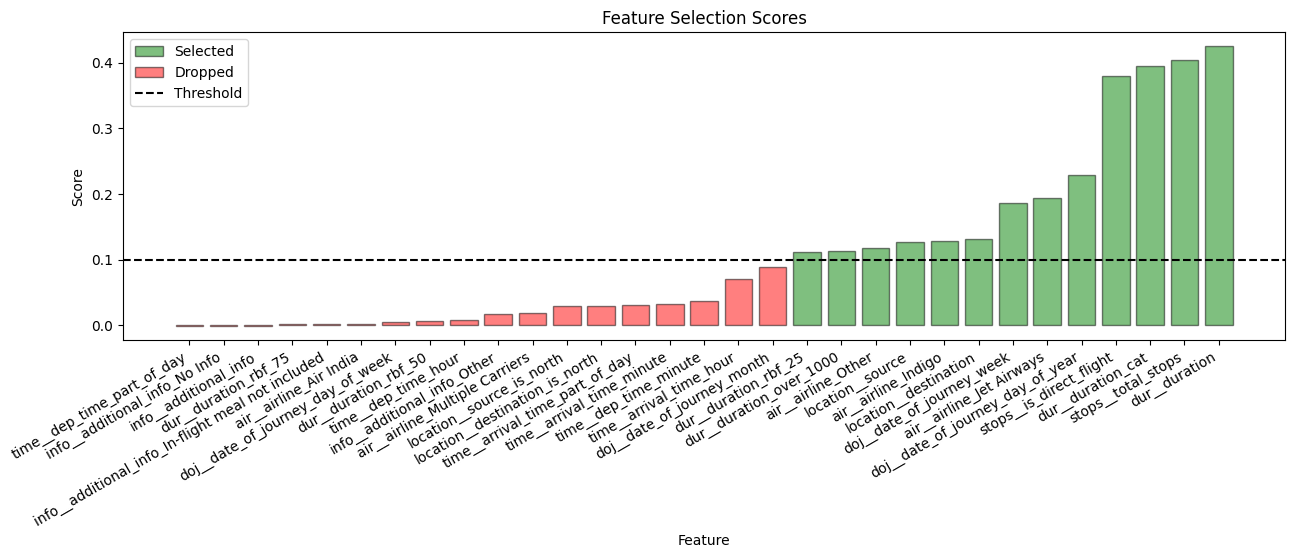

In [94]:
THRESHOLD = 0.1

selected_bar = None
dropped_bar = None
colors = ["red" if score < THRESHOLD else "green" for score in sorted_feat_imp.values()]


fig, ax = plt.subplots(figsize=(15, 4)) 

for i, (feature, score) in enumerate(sorted_feat_imp.items()):
	params = dict(
		x=i,
		height=score,
		edgecolor="black",
		alpha=0.5
	)
	
	if score < THRESHOLD:
		bar = ax.bar(
			color="red",
			**params
		)
		if not dropped_bar:
			dropped_bar = bar[0]
	else:
		bar = ax.bar(
			color="green",
			**params
		)
		if not selected_bar:
			selected_bar = bar[0]

thresh_line = ax.axhline(
	y=0.1,
	color="black",
	linestyle="--"
)

ax.set_xticks(
	ticks=range(len(sorted_feat_imp)),
	labels=list(sorted_feat_imp.keys()),
	rotation=30,
	ha="right"
)

ax.set(
	xlabel="Feature",
	ylabel="Score",
	title="Feature Selection Scores"
)

ax.legend(
	handles=[selected_bar, dropped_bar, thresh_line],
	labels=["Selected", "Dropped", "Threshold"],
	loc="upper left"
)

plt.show()

- The dataset went upto 31 columns after Feature Engineering
- The Feature Selection algorithm selected 13 features out of that